In [77]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [78]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=64):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),        
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [79]:
def potential(x,k,l,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=-10/x-8*(torch.sin(torch.pi*x/10))**2*torch.exp(-x/15)
    return poten

In [80]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

###### 氢原子能级
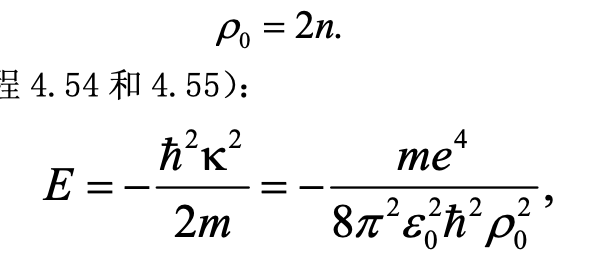
##### 相当于$\alpha=e^2/(4\pi \epsilon_0)=1,E_n=-2m/\hbar^2*\alpha^2/(4n^2)$
##### and $ a_{bohr}=2*k/\alpha, k=\hbar^2/2m $

In [81]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
# 控制势函数的大小
scale=10

en_num=20
extend_num=10
epoch=200000
lr=0.01


In [82]:
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

real_en=eigenvalues[:en_num].detach()
print('initial eigenvalues check:')
print(eigenvalues[:en_num+extend_num])

initial eigenvalues check:
tensor([-49.2664, -12.7689,  -7.6508,  -7.1597,  -6.5087,  -5.6175,  -4.6690,
         -3.6954,  -3.2892,  -2.7294,  -2.5761,  -1.9258,  -1.8135,  -1.6713,
         -1.3562,  -1.1761,  -1.0468,  -0.8889,  -0.8406,  -0.7502,  -0.5553,
         -0.5159,  -0.4992,  -0.4048,  -0.3094,  -0.3029,  -0.2686,  -0.2219,
         -0.2048,  -0.1651], device='cuda:0')


In [83]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=50,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    '''output=NN(input)
    diag=torch.diag(output.flatten())'''
    
    output=eigenvalues[:en_num]
    loss=loss_fn(output,real_en)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        print('\nepoch:',i)
        print(eigenvalues[:en_num+extend_num])
        print(real_en)
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:4.764888286590576,time:0.11278724670410156,lr:0.01

epoch: 0
tensor([-1.5522, -1.4793, -1.4190, -1.3654, -1.3161, -1.2698, -1.2259, -1.1839,
        -1.1432, -1.1039, -1.0655, -1.0285, -0.9915, -0.9559, -0.9194, -0.8851,
        -0.8505, -0.8163, -0.7824, -0.7487, -0.7153, -0.6820, -0.6487, -0.6155,
        -0.5824, -0.5490, -0.5156, -0.4825, -0.4489, -0.4151], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([-49.2664, -12.7689,  -7.6508,  -7.1597,  -6.5087,  -5.6175,  -4.6690,
         -3.6954,  -3.2892,  -2.7294,  -2.5761,  -1.9258,  -1.8135,  -1.6713,
         -1.3562,  -1.1761,  -1.0468,  -0.8889,  -0.8406,  -0.7502],
       device='cuda:0')
epoch:10,loss:4.522247314453125,time:1.125901222229004,lr:0.01

epoch: 10
tensor([-5.6414, -5.4781, -5.3444, -5.2262, -5.1184, -5.0179, -4.9230, -4.8328,
        -4.7465, -4.6635, -4.5833, -4.5056, -4.4300, -4.3565, -4.2848, -4.2147,
        -4.1462, -4.0790, -4.0132, -3.9486, -3.8852, -3.8228, -3.7615, -3.7011,
        -3

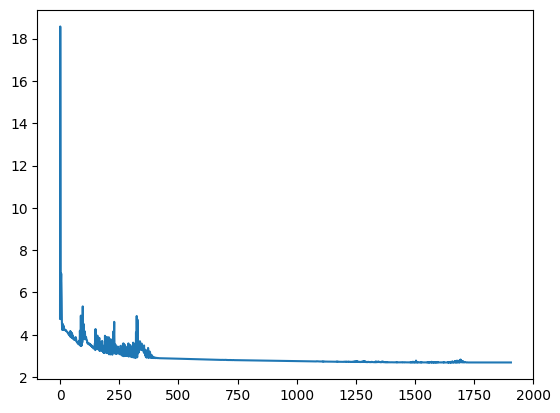

In [84]:
plt.plot(loss_list)
plt.show()

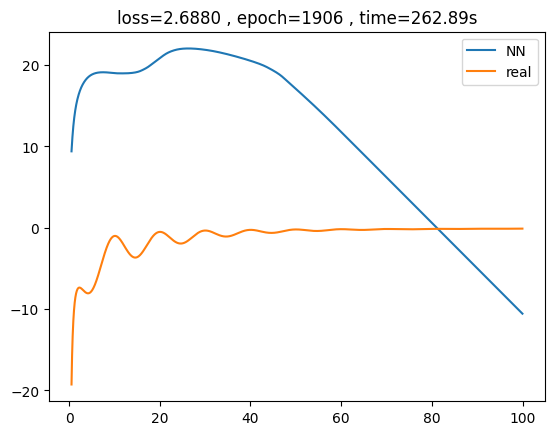

In [85]:
La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[20:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()
